# SunPy 0.6

We are happy to announce the release of SunPy 0.6 our biggest release yet! For a full list of all of the features in this release check out the [CHANGELOG.md](https://github.com/sunpy/sunpy/blob/0.6/CHANGELOG.md). Here is a quick rundown of some of the featured new capabilities.
 * **Sample Data** Sample data has been removed from the SunPy codebase but can now be downloaded automatically when you need it. This means that we can now be providing much more and varied sample data for everyone to play with. This also means that SunPy has lost a few pounds and is slimmer and trimmer.
 * **Units and Quantities!** SunPy now makes use of physical quantities. This is made possible by Astropy's great [units support](http://astropy.readthedocs.org/en/latest/units/). This means that you don't have to consistently check the documentation to see what units keywords or output is in. This also means that all of the code is now dimensionionally consistent by design. That our code is less error prone and so is yours.
 * **Documentation Updates Galore!** The documentation has gotten a lot of love and attention. We've cleaned those dusty corners. We've also added documentation for all of the instruments so you can get some quick background on the data you are using and links to get more information if you need it. We've also made it much easier to add plots to the documentation and these plots are generated on the fly so they are always up to date. There is still more work to do but this is a huge improvement.
 * **Improvements to Color Table and Normalization Improvements** We've updated all of the normalizations to remove our nasty habit of clipping the brightest pixels. We've gone through and chosen appropriate normalizations so that plots for each data source (e.g. AIA, EIT, LASCO) look the best they can right out of the box. That means less work for you.
 * **Plot Settings** We've normalized plot settings for Maps. We've provided an easy shortcut to those settings you are most likely going to want to change like the color table and normalization in the new `plot_settings` property.
 * **Lots of Bug Fixes**

The rest of this document demonstrates some of these capabilities. This post is based on an ipython notebook which you can [download yourself]() to test out and play around yourself.

In [1]:
# ipython settings
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.figsize'] = (7, 7)
import warnings
warnings.filterwarnings("ignore")

# Sample Data
SunPy no longer ships with sample data but you can download it easily.

In [3]:
import sunpy.data
sunpy.data.download_sample_data()

Unpacking: aia.lev1.193A_2013-09-21T16_00_06.84Z.image_lev1.fits


now when you import the sample data you should have all of the links to the files like before

In [3]:
import sunpy.data.sample

In [4]:
sunpy.data.sample.AIA_193_IMAGE

'/Users/schriste/sunpy/data/sample_data/aia.lev1.193A_2013-09-21T16_00_06.84Z.image_lev1.fits'

for more info see the [documentation](http://docs.sunpy.org/en/stable/guide/acquiring_data/sample-data.html#sample-data)

# Units and Quantities
Units are now sprinkled throughout the code both for input and output. Here are a few examples. Before we begin here are two ways to easily create a physical quantity.

In [5]:
import astropy.units as u
from astropy.units import Quantity
from sunpy.sun.constants import au
from astropy.constants import c, k_B

In [6]:
5 * u.cm

<Quantity 5.0 cm>

In [7]:
Quantity(3 * 10 ** 8, 'cm/s')

<Quantity 300000000.0 cm / s>

In [8]:
from sunpy.map import Map
aia = Map(sunpy.data.sample.AIA_193_IMAGE)

In [9]:
aia.wavelength

<Quantity 193.0 Angstrom>

In [10]:
aia.wavelength.to('nm')

<Quantity 19.3 nm>

In [11]:
aia.center

Pair(x=<Quantity 3.532201323570007 arcsec>, y=<Quantity 0.9010710000000017 arcsec>)

In [12]:
aia.dimensions

Pair(x=<Quantity 4096.0 pix>, y=<Quantity 4096.0 pix>)

Pixels are a unit too!

In [13]:
aia.scale.x * 100 * u.pix

<Quantity 60.0714 arcsec>

Let's first convert from an angular size to a physical size

In [14]:
angular_conversion = np.sin(1 * u.arcsec) * au / u.arcsec

In [15]:
angular_conversion.to('km/arcsec')

<Quantity 725.2709437993128 km / arcsec>

In [16]:
(aia.scale.x * 100 * u.pix * angular_conversion).to('Mm')

<Quantity 43.56804097334604 Mm>

Now let's try input. submap() now requires quantities as input

In [17]:
smap = aia.submap([400, 500] * u.arcsec, [-200, -300] * u.arcsec)
smap

SunPy AIAMap
---------
Observatory:	 SDO
Instrument:	 AIA 2
Detector:	 AIA
Measurement:	 193.0 Angstrom
Wavelength:	 193.0 Angstrom
Obs Date:	 2013-09-21 16:00:06
dt:		 1.999592 s
Dimension:	 [ 166.  167.] pix
scale:		 [ 0.600714  0.600714] arcsec / pix

array([[364, 355, 339, ..., 240, 240, 217],
       [341, 360, 331, ..., 255, 242, 254],
       [367, 329, 306, ..., 241, 256, 261],
       ..., 
       [195, 187, 180, ..., 262, 268, 279],
       [173, 185, 181, ..., 260, 261, 296],
       [166, 183, 184, ..., 267, 266, 290]], dtype=int16)

In [18]:
# time it takes for light to travel from the Sun to the Earth
dt = au / c
dt.to('min')

<Quantity 8.316746397269274 min>

Let's calculate the thermal energy associated with a flare (see this [paper](http://labs.adsabs.harvard.edu/adsabs/abs/2002SoPh..210..287S/)). Say you measured the angular size of the source and the temperature and the emission measure from the spectrum.

In [19]:
angular_size = 2.5 * u.arcsec
temperature = 19.7 * 10**6 * u.Kelvin
emission_measure = Quantity(0.2 * 10 ** 49, 'cm-3')

In [20]:
radius = 2.8 * u.arcsec * angular_conversion

And now let's calculate the volume assuming a sphere

In [21]:
volume = 4 * np.pi / 3 * radius ** 3
volume.to('cm3')

<Quantity 3.508031948452974e+25 cm3>

Let's assume a filling factor of 1 and calculate the density of the source

In [22]:
filling_factor = 1
density = np.sqrt(filling_factor * emission_measure / volume)
density.decompose().cgs

<Quantity 238771906917.62872 1 / cm3>

And now let's finally get the thermal energy

In [23]:
thermal_energy = 3 * k_B * temperature * np.sqrt(emission_measure * volume * filling_factor)
thermal_energy.decompose()

<Quantity 6.834668712358113e+21 kg m2 / s2>

But we want it in erg so let's convert to cgs

In [24]:
thermal_energy.cgs

<Quantity 6.834668712358112e+28 erg>

If we had made a mistake somewhere with our units for example giving the filling factor a unit of cm we would have gotten an error

In [25]:
filling_factor = 1 * u.cm
thermal_energy = 3 * k_B * temperature * np.sqrt(emission_measure * volume * filling_factor)
thermal_energy.to('erg')

UnitConversionError: 'cm(1/2) J m(3/2) / cm(3/2)' and 'erg' (energy) are not convertible

# Documentation Updates
Major updates throughout. Of course, this is most easily seen when browsing our documentation [online](http://docs.sunpy.org) but they are also useful reference when analyzing data. For example... 

In [26]:
print(aia.__doc__)

AIA Image Map.

    The Atmospheric Imaging Assembly is a set of four telescopes that employ
    normal-incidence, multi-layer coated optics to provide narrow-band imaging
    of the Sun. It provides high resolution full-disk images of the corona and
    transition region up to 0.5 solar radii above the solar limb with 1.5
    arcsecond angular resolution and 12-second temporal resolution. It observes
    the Sun in the following seven extreme ultraviolet bandpasses: 94 A
    (Fe XVIII), 131 A (Fe VIII, XXI), 171 A (Fe IX), 193 A (Fe XII, XXIV),
    211 A (Fe XIV), 304 A (He II), 335 A (Fe XVI). One telescope observes
    in the visible 1600 A (C IV) and the nearby continuun (1700 A).

    References
    ----------
    * `SDO Mission Page <http://sdo.gsfc.nasa.gov>`_
    * `Instrument Page <http://aia.lmsal.com>`_
    * `Fits Header keywords <http://jsoc.stanford.edu/doc/keywords/AIA/AIA02840_A_AIA-SDO_FITS_Keyword_Documents.pdf>`_
    * `Analysis Guide <https://www.lmsal.com/sdodocs/d

You can also access it in your ipython notebook like so

In [ ]:
aia?

And here it is rendered on our [documentation](http://docs.sunpy.org/en/stable/api/sunpy.map.sources.AIAMap.html#sunpy.map.sources.AIAMap)

This is availabe for all of the LightCurve objects. Here is just one example.

In [27]:
from sunpy import lightcurve as lc
from sunpy.time import TimeRange
goes = lc.GOESLightCurve.create(TimeRange('2012/06/01', '2012/06/05'))

In [28]:
print(goes.__doc__)


    GOES XRS LightCurve

    Each GOES satellite there are two X-ray Sensors (XRS) which provide solar X
    ray fluxes for the wavelength bands of 0.5 to 4 Å (short channel)
    and 1 to 8 Å (long channel). Most recent data is usually available one or two days late.

    Data is available starting on 1981/01/01.

    Examples
    --------
    >>> from sunpy import lightcurve as lc
    >>> from sunpy.time import TimeRange
    >>> goes = lc.GOESLightCurve.create(TimeRange('2012/06/01', '2012/06/05'))
    >>> goes.peek()   # doctest: +SKIP

    References
    ----------
    * `GOES Mission Homepage <http://www.goes.noaa.gov>`_
    * `GOES XRS Homepage <http://www.swpc.noaa.gov/products/goes-x-ray-flux>`_
    * `GOES XRS Guide <http://ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf>`_
    * `NASCOM Data Archive <http://umbra.nascom.nasa.gov/goes/fits/>`_
    


and here is it's doc string rendered in our [documentation](http://docs.sunpy.org/en/stable/api/sunpy.lightcurve.GOESLightCurve.html#sunpy.lightcurve.GOESLightCurve)

# Improvements to Color Table and Normalization
SunPy provides default color tables and normalizations (this is how the data is scaled to be converted to a color, note that it does not touch the data). This is so that the user doesn't have to think about it. Unfortunately our default normalization was less than optimatl and would clip the brightest regions. We have fixed this by choosing custom normalizations for each data set with the philosophy that ALL data should be shown, from the dimmest to the brightest. Here are a few examples

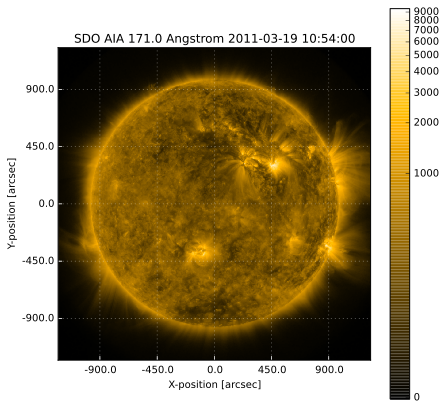

In [29]:
aia = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

aia.plot()
plt.colorbar()
plt.show()

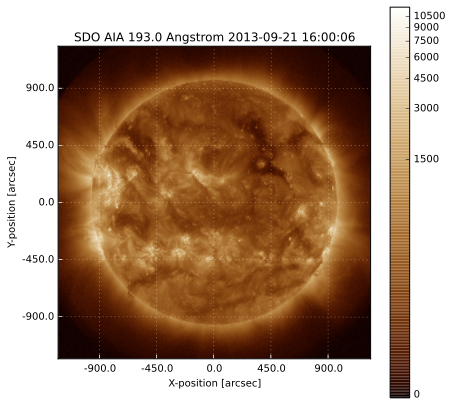

In [30]:
aia = sunpy.map.Map(sunpy.data.sample.AIA_193_IMAGE)

aia.plot()
plt.colorbar()
plt.show()

Of course this does not always look great. For example,

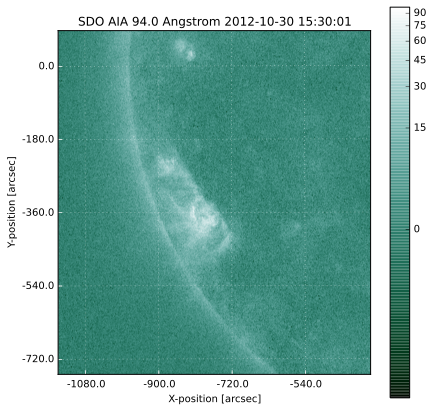

In [31]:
aia = sunpy.map.Map(sunpy.data.sample.AIA_94_CUTOUT)

aia.plot()
plt.colorbar()
plt.show()

This is because

In [32]:
aia.min()

-5.0

# Plot Settings
This is why we've made it much easier to access plot settings! We've put all of these settings in one place.

In [33]:
aia.plot_settings

{'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x10b6c4ad0>,
 'interpolation': 'nearest',
 'norm': <astropy.visualization.mpl_normalize.ImageNormalize at 0x10ccd3d50>,
 'origin': 'lower'}

In [34]:
norm = aia.plot_settings['norm']

In [35]:
norm.vmin = 0

<matplotlib.colorbar.Colorbar instance at 0x11270aa28>

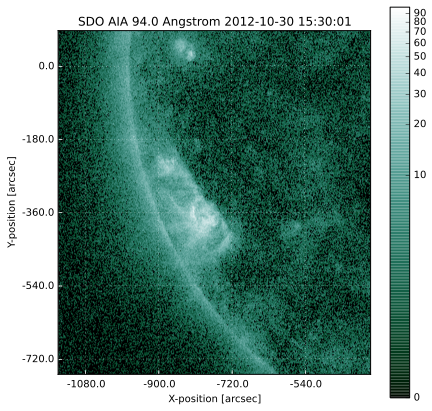

In [36]:
aia.plot()
plt.colorbar()

One more example

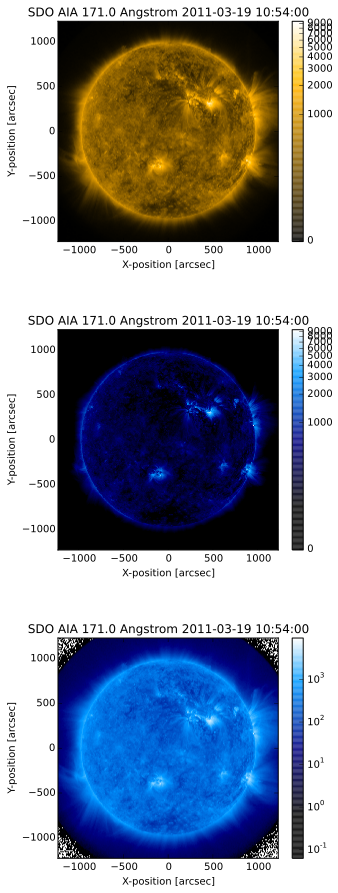

In [37]:
from matplotlib import colors
aia = Map(sunpy.data.sample.AIA_171_IMAGE)

fig = plt.figure(figsize=(5, 15))
ax1 = fig.add_subplot(3,1,1)
aia.plot()
plt.colorbar()
ax2 = fig.add_subplot(3,1,2)
# the sunpy color maps are now registered with matplotlib
aia.plot_settings['cmap'] = plt.get_cmap('sohoeit171')
aia.plot()
plt.colorbar()
ax3 = fig.add_subplot(3,1,3)
aia.plot_settings['norm'] = colors.LogNorm()
aia.plot()
fig.subplots_adjust(hspace=0.4)
plt.colorbar()
plt.show()

For more information check the [plotting documentations](http://docs.sunpy.org/en/stable/guide/data_types/maps.html#plotting-keywords)